# DSCI 100 - Proposal
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

The topic of our project is centered around a data set which looks at student performance in two different schools located in Portugal. The dataset includes a variety of different factors that could play a role in student performance. The dataset also tracks first and second period grades as well as final grades in Portugese, which can be used to determine the change in student performance.
A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. This information collected includes student grades, social and study habits, and family background.  The data tracks the students’ grades in two subjects, Mathematics and Portuguese. 
 
We will try to answer the following question in this report:
Can we predict whether a student  pursue higher education,  given sex, address, parent education, class failures, family educational support, and Portuguese grades?


## Preliminary exploratory data analysis

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Read data set from the web into R
student_port <- read_delim("data/student-por.csv",delim = ";")

# Clean and wrangle data into tidy format
student_select <- student_port %>%
                select("sex", "address", "Medu", "Fedu", "failures", "famsup", "higher", "G1", "G2", "G3") %>%
                mutate(higher = as_factor(higher))

# Obtain training set:
# We chose strata = 0.75 since the data set is large enough that we will still 
# have a reasonable amount of training and testing data with this split.
student_split <- initial_split(student_select, prop = 0.75, strata = higher) 

student_train <- training(student_split)
student_train

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



sex,address,Medu,Fedu,failures,famsup,higher,G1,G2,G3
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
F,U,4,4,0,no,yes,0,11,11
F,U,1,1,0,yes,yes,9,11,11
F,U,1,1,0,no,yes,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
F,U,1,1,0,no,yes,11,12,9
M,U,3,1,0,no,yes,10,10,10
M,R,3,2,0,no,yes,10,11,11


In [3]:
# number of observations in higher(target variable)
counts <- student_train %>%
        group_by(higher) %>%
        summarize(n=n())   
counts

# average grade of term 1, term 2, and final Portuguese grade
ave_grade <- student_train %>%
            summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade

`summarise()` ungrouping output (override with `.groups` argument)



higher,n
<fct>,<int>
yes,435
no,52


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.32033,11.55441,11.86858


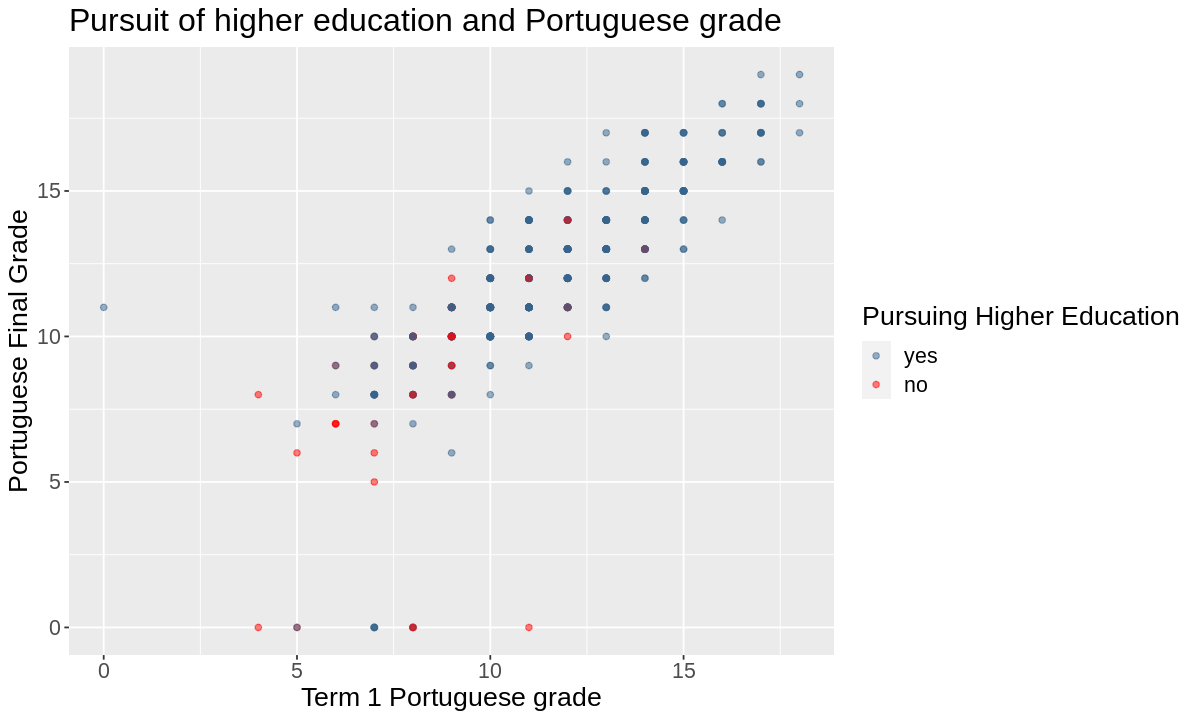

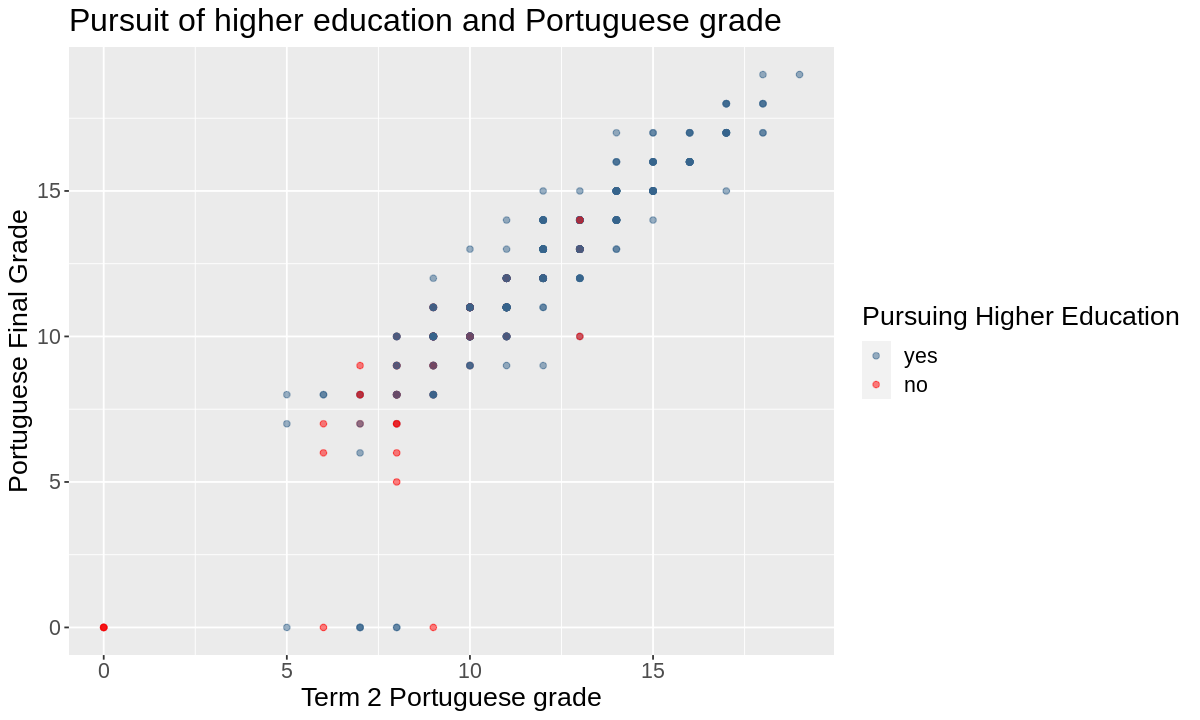

In [4]:
options(repr.plot.width=10, repr.plot.height=6)

# comparing the distribution of Portuguese grades and higher
student_por_plot1 <- student_train %>%
                select(G1, G3, higher) %>%
                ggplot(aes(x = G1, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 1 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                scale_colour_manual(values = c("yes" = "steelblue4","no"="red")) +
                theme(text = element_text(size=16))        

student_por_plot2 <- student_train %>%
                select(G2, G3, higher) %>%
                ggplot(aes(x = G2, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 2 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                scale_colour_manual(values = c("yes" = "steelblue4","no"="red")) +
                theme(text = element_text(size=16))  

student_por_plot1
student_por_plot2

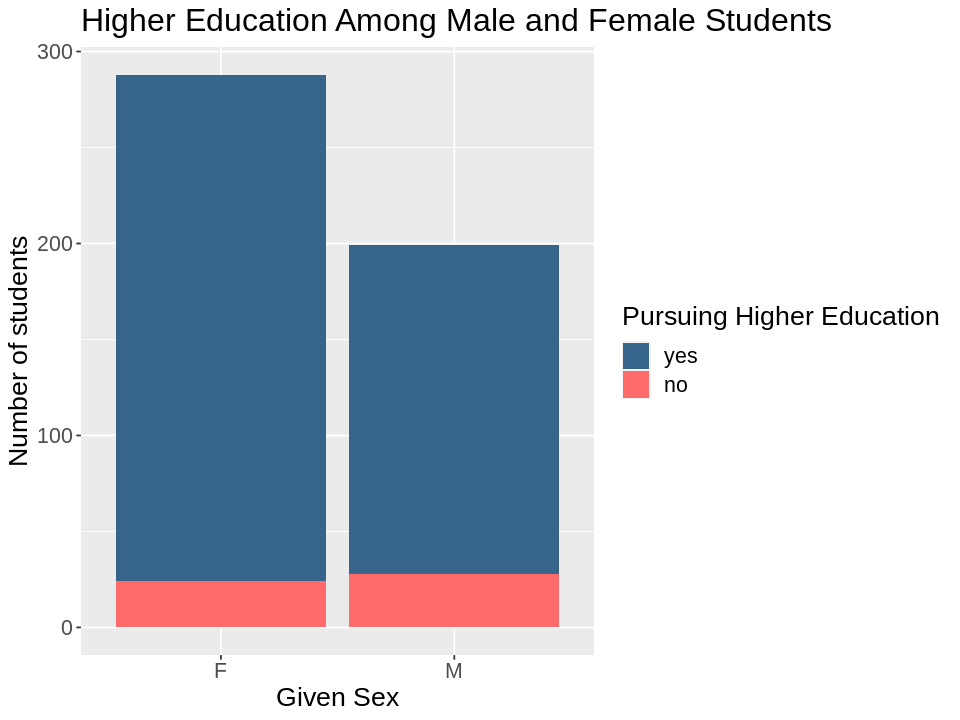

In [5]:
options(repr.plot.width=8, repr.plot.height=6)
# Distribution of student's choice by given sex
student_gender <- student_train %>%
                select(sex, higher) %>%
                ggplot(aes(x=sex, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Given Sex", y = "Number of students", fill = "Pursuing Higher Education", 
                     title = "Higher Education Among Male and Female Students")+
                theme(text = element_text(size=16))
student_gender

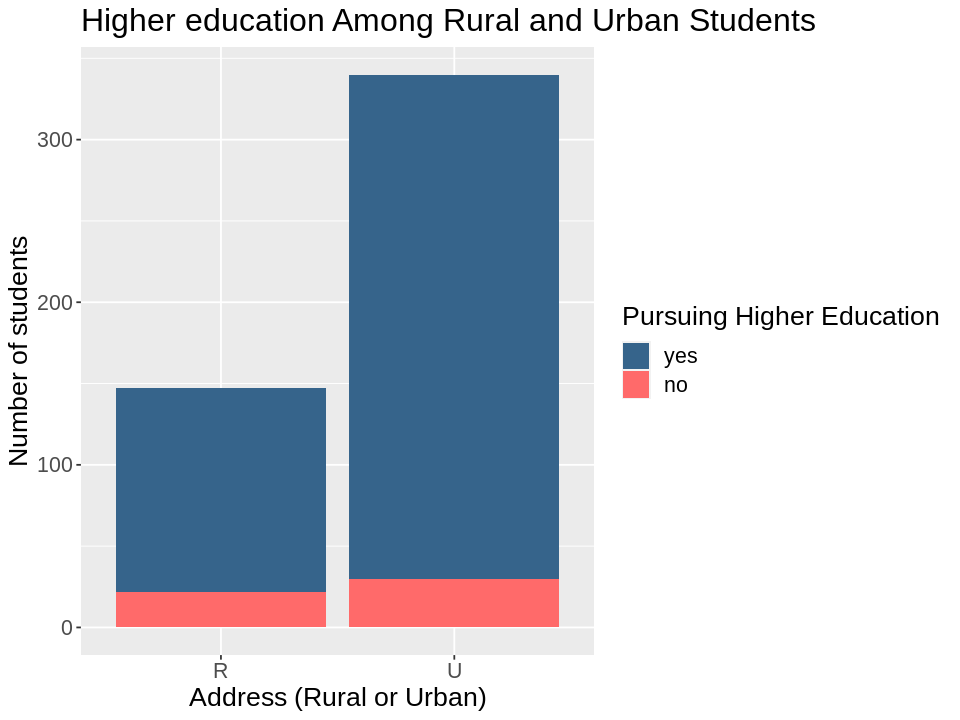

In [6]:
options(repr.plot.width=8, repr.plot.height=6)

# Distribution of student's choice by address (rural vs urban)
student_address <- student_train %>%
                select(address, higher) %>%
                ggplot(aes(x=address, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Number of students", fill = "Pursuing Higher Education", 
                     title = "Higher education Among Rural and Urban Students")+
                theme(text = element_text(size=16))
student_address



`summarise()` regrouping output by 'address' (override with `.groups` argument)



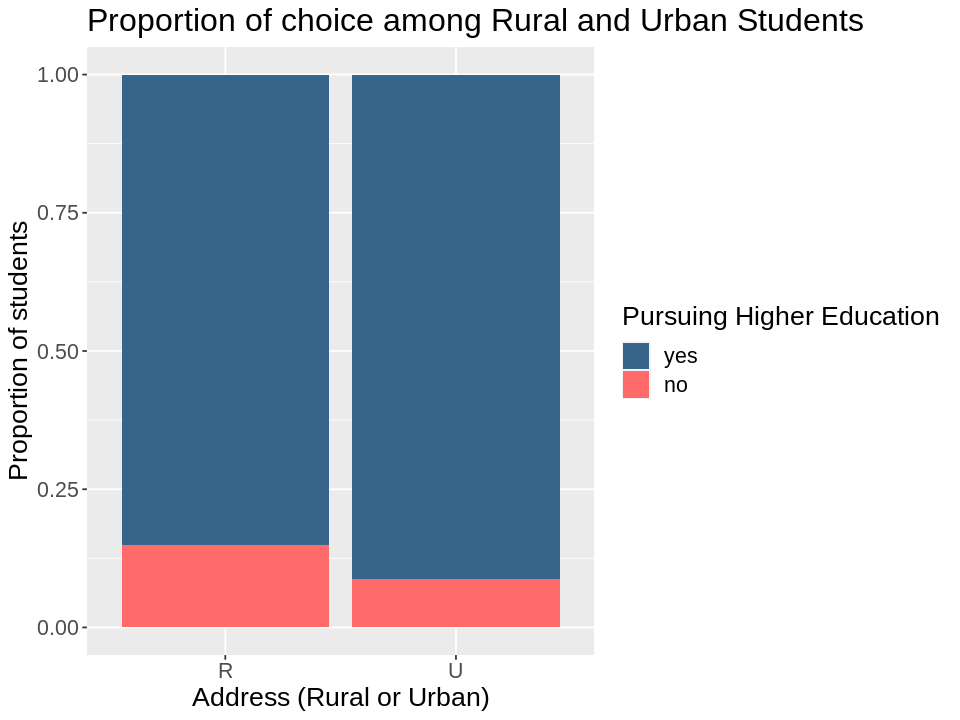

In [7]:
address_n_higher <- student_train %>%
            select(address, higher)%>%
            group_by(address, higher)%>%
            summarize(n = n())
address_plot <- ggplot(address_n_higher, aes(x = address, y = n, fill = higher)) +
                    geom_bar(stat = "identity", position = "fill")+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Proportion of students", fill = "Pursuing Higher Education",
                    title = "Proportion of choice among Rural and Urban Students")+
                theme(text = element_text(size=16))
address_plot

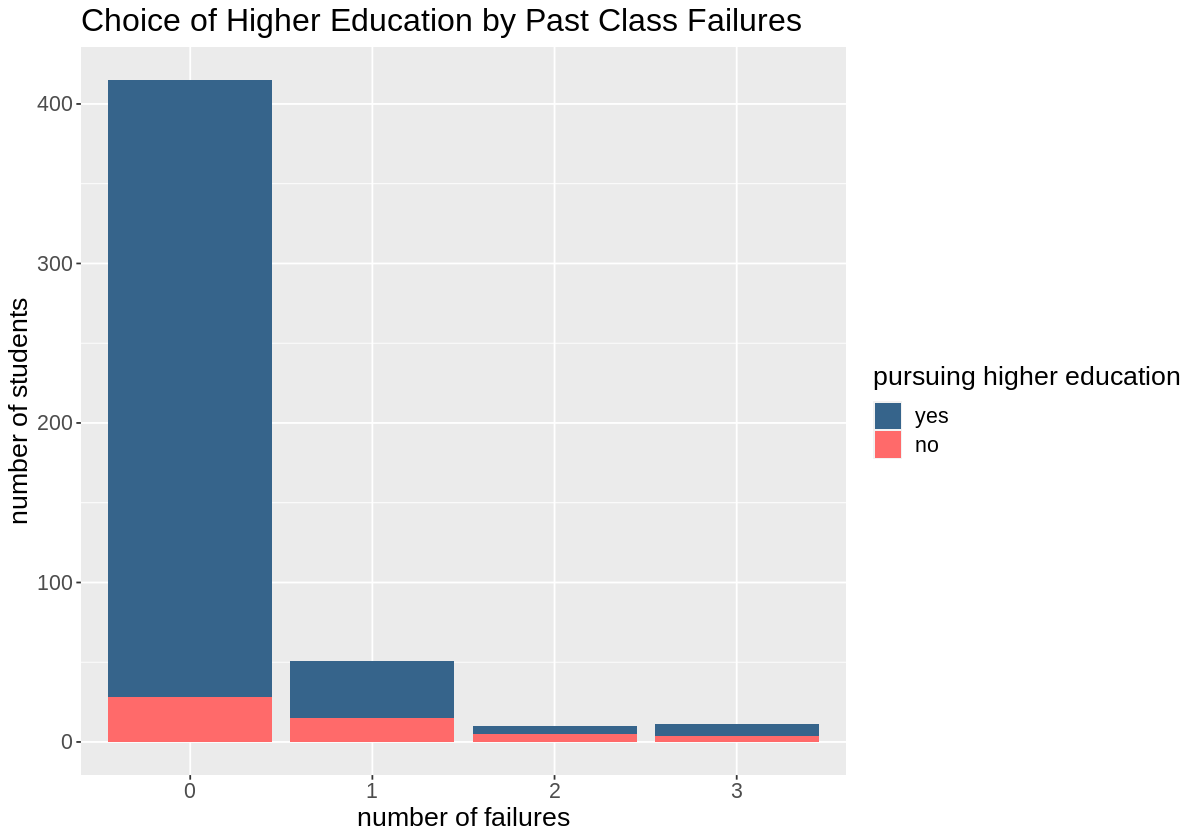

In [8]:
options(repr.plot.width=10, repr.plot.height=7)
student_failures <- student_train %>%
                select(failures, higher) %>%
                ggplot(aes(x=as.factor(failures), y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(y = "number of students", x = "number of failures", fill = "pursuing higher education",
                    title = "Choice of Higher Education by Past Class Failures")+
                theme(text = element_text(size=16))
student_failures

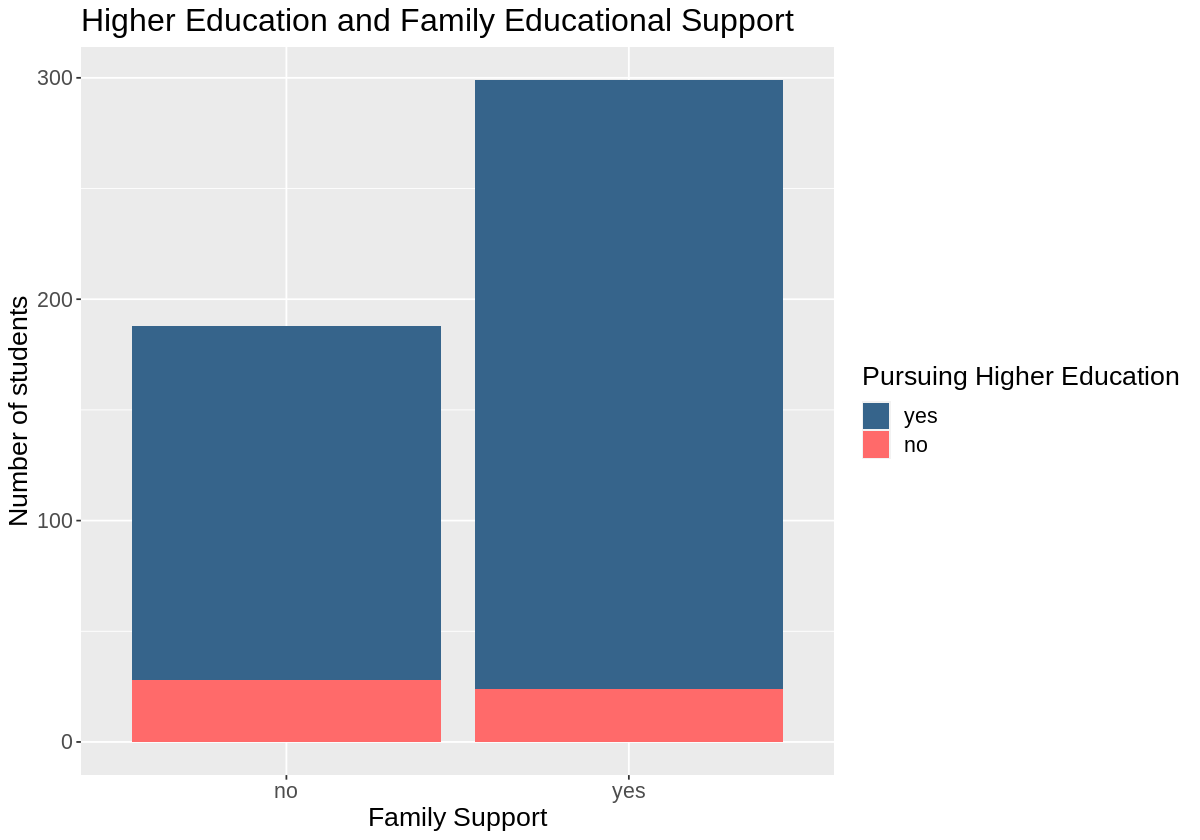

In [9]:
family_support <- student_train %>%
                select(famsup, higher) %>%
                ggplot(aes(x=famsup, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Family Support", y = "Number of students", fill = "Pursuing Higher Education",
                    title = "Higher Education and Family Educational Support")+
                theme(text = element_text(size=16))
family_support

## Methods

In order to create our prediction model, we will be looking at seven predictor variables: given sex, address (rural or urban), parents’ education, number of previous class failures, family educational support, and Portuguese course grades. 

First, we wanted to  visualize the effect of a student’s grades on their choice to pursue higher education. We created a graph of each student’s Period 1 Portuguese grade vs. Final Portuguese grade and coloured the data points by the variable “higher”. This allows us to see the distribution of “higher” with respect to grades. 
We also wanted to visualize the distribution of our target variable with respect to the other categorical values. We created three bar graphs that show the number of students of students choosing yes or no depending on given sex, rural or urban address, and number of previous class failures.

## Expected outcomes and significance¶
We expect to see a relationship between the target variable, “higher education”, and the chosen predictor variables. We expect that we will be able to use these predictor variables to determine whether a student will choose to pursue higher education.

The impact of these findings could be very significant in that they can help bring to light reasons that would cause Portugese students to say no to higher education. It could help us understand the rate of female vs male students saying yes to higher education and that data can be taken and compared against the remaining factors to provide relevant insights. Our analysis can be used to determine which students might be at risk of not pursuing higher education. These findings can help determine ways to support students and to encourage them to explore the opportunity of pursuing higher education.

A few questions that our findings can lead to are:

* Why do certain aspects have such a sway on students opting for higher education?
* How can we reduce this gap?
* How can we provide resources to these students?

## Citation:
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#
